In [1]:
import pandas as pd
import numpy as np

import pickle

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
bohb_best_params = {'eta': 0.1, 'max_depth': 13, 'min_child_weight': 3, 'gamma': 0.002521802184441313, 'lambda': 2, 'alpha': 0.5, 'scale_pos_weight': 0.995725558531313, 'subsample': 0.7121859300080736, 'colsample_bytree': 0.8584091862468555, 'n_estimators': 293}
xgb_prelim_with_contract = XGBClassifier(**bohb_best_params, n_jobs=-1, random_state=42)
xgb_prelim_with_contract_bal = XGBClassifier(n_jobs=-1, random_state=42)

# X_test_sfs_xgb = pd.read_pickle('models/X_test_sfs_xgb.pkl')
# training_data_full_bal = pd.read_parquet('data/parquet_files/training_data_rfm.parquet')
# _, _, _, y_test_full_bal = train_test_split(training_data_full_bal.drop(columns=['Flag']), training_data_full_bal['Flag'], test_size=0.2, random_state=42)

training_data_full= pd.read_parquet('data/parquet_files/training_data_rfm_alt.parquet')
training_data_full_bal= pd.read_parquet('data/parquet_files/training_data_rfm.parquet')

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(training_data_full.drop(columns=['Flag']), training_data_full['Flag'], test_size=0.2, random_state=42)
X_train_full_bal, X_test_full_bal, y_train_full_bal, y_test_full_bal = train_test_split(training_data_full_bal.drop(columns=['Flag']), training_data_full_bal['Flag'], test_size=0.2, random_state=42)

xgb_prelim_with_contract.fit(X_train_full, y_train_full)
xgb_prelim_with_contract_bal.fit(X_train_full_bal, y_train_full_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

Accuracy (Imbalanced):  0.9797398699349675
Precision (Imbalanced):  0.9517661825354133
Recall (Imbalanced):  0.9897445459630804
F1 (Imbalanced):  0.970383912248629
Accuracy (Balanced):  0.8849009900990099
Precision (Balanced):  0.8980777827447475
Recall (Balanced):  0.7410549612689045
F1 (Balanced):  0.8120452708164916


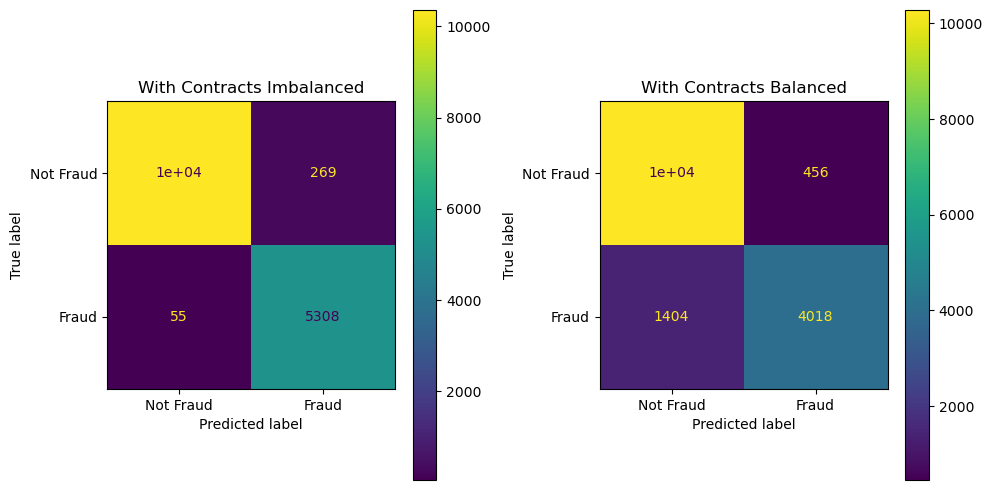

In [3]:
def print_metrics_and_plot_cm(model, X_test, y_test, method):
    pred = model.predict(X_test)
    print(f'Accuracy ({method}): ', accuracy_score(y_test, pred))
    print(f'Precision ({method}): ', precision_score(y_test, pred))
    print(f'Recall ({method}): ', recall_score(y_test, pred))
    print(f'F1 ({method}): ', f1_score(y_test, pred))
    cm = confusion_matrix(y_test, pred)
    return ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

disp_rand = print_metrics_and_plot_cm(xgb_prelim_with_contract, X_test_full, y_test_full, 'Imbalanced')
disp_rand.plot(ax=axes[0])
axes[0].set_title('With Contracts Imbalanced')

disp_bohb = print_metrics_and_plot_cm(xgb_prelim_with_contract_bal, X_test_full_bal, y_test_full_bal, 'Balanced')
disp_bohb.plot(ax=axes[1])
axes[1].set_title('With Contracts Balanced')

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

test_set = pd.read_parquet('data/parquet_files/test_df_alt.parquet')
scam_addresses_in_train_test = pd.read_pickle('data/pickle_files/scam_addresses_in_train_test_alt.pkl')

test_set['Flag'] = test_set['address'].apply(lambda x: 1 if x in scam_addresses_in_train_test else 0)

chosen_columns = X_test_full.columns
chosen_columns_bal = X_test_full_bal.columns

fill_values = {'median_recency_out':0, 'median_recency_in':0, 'num_outliers_eth_out':0, 'num_outliers_eth_in': 0,
               'daily_from_gini_index': 1000, 'daily_to_gini_index': 1000, 'weekly_from_gini_index': 1000, 
               'weekly_to_gini_index': 1000, 'daily_total_gini_index': 1000, 'weekly_total_gini_index': 1000}
test_set = test_set.fillna(value=fill_values)
test_set_pred = test_set[chosen_columns.append(pd.Index(['Flag']))]
test_set_pred_bal = test_set[chosen_columns_bal.append(pd.Index(['Flag']))]

353
50


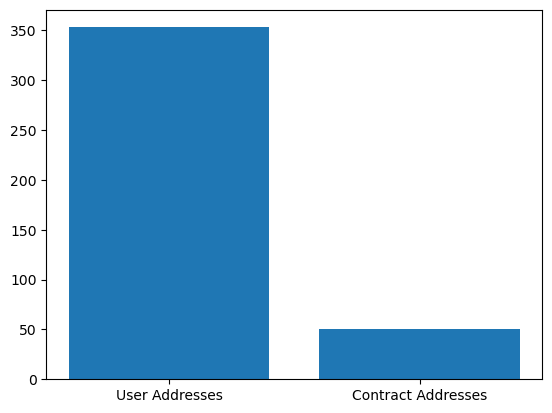

In [5]:
from random import sample
from math import floor

from alchemy_api import AlchemyApi
import pandas as pd
import numpy as np

import random
from web3 import Web3
# choose a Provider of your choice

import concurrent.futures
import re

test_set_fraud_addresses = test_set[test_set['Flag'] == 1]['address'].unique().tolist()

alchemy = AlchemyApi()

def get_address_type(address, api_keys, alchemy_url):
    check_sum_address = Web3.to_checksum_address(address)
    api_key = api_key_rotation(api_keys)
    full_url = alchemy_url + api_key
    w3 = Web3(Web3.HTTPProvider(full_url))
    response = w3.eth.get_code(check_sum_address)
    return response.hex() == '0x'

def api_key_rotation(api_keys):
    index = random.randint(0, len(api_keys) - 1)
    return api_keys[index]

user_addresses = []
contract_addresses = []
api_keys = alchemy.get_api_keys()
alchemy_url = alchemy.get_api_url()

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
    future_to_address = {executor.submit(get_address_type, address, api_keys, alchemy_url): address for address in test_set_fraud_addresses}
    for future in concurrent.futures.as_completed(future_to_address):
        address = future_to_address[future]
        try:
            is_user_address = future.result()
            if is_user_address:
                user_addresses.append(address)
            else:
                contract_addresses.append(address)
        except TypeError as e:
            continue

print(len(user_addresses))
print(len(contract_addresses))

#plot bar plot length of user_addresses vs contract_addresses
plt.bar(['User Addresses', 'Contract Addresses'], [len(user_addresses), len(contract_addresses)])
plt.show()

In [6]:
X = test_set_pred.drop(columns=['Flag'])
y = test_set_pred['Flag']
X_bal = test_set_pred_bal.drop(columns=['Flag'])
y_bal = test_set_pred_bal['Flag']

Prelim Test Set Accuracy:  0.9719736384189732
Prelim Test Set Accuracy (Balanced):  0.9531761302230779
Prelim Test Set F1:  0.0009370241674149846
Prelim Test Set F1 (Balanced):  0.0023452677514016183


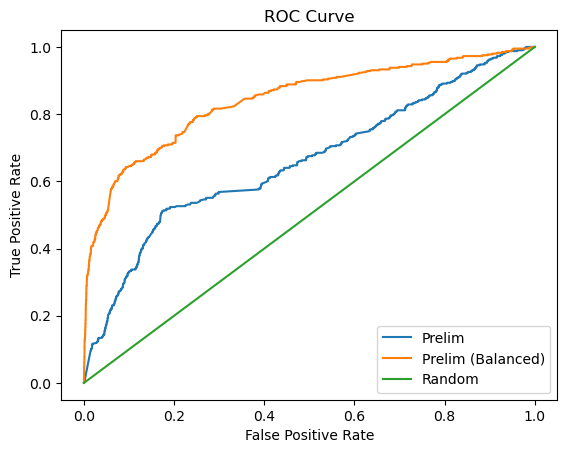

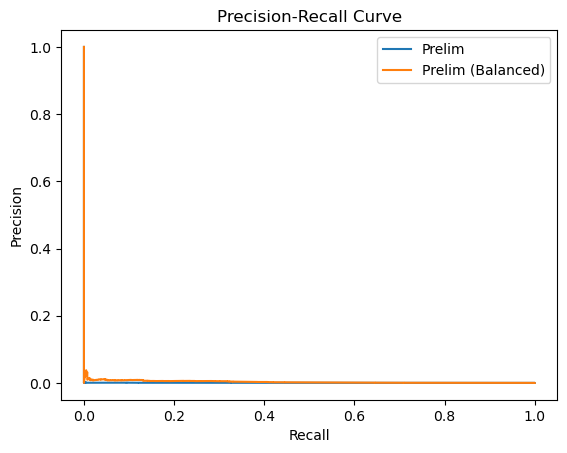

In [7]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, precision_recall_curve

pred_prelim = xgb_prelim_with_contract.predict(X)
pred_prelim_proba = xgb_prelim_with_contract.predict_proba(X)[:,1]
test_set['Predictions_Prelim'] = pred_prelim
test_set['Predictions_Prelim_Proba'] = pred_prelim_proba

pred_prelim_bal = xgb_prelim_with_contract_bal.predict(X_bal)
pred_prelim_bal_proba = xgb_prelim_with_contract_bal.predict_proba(X_bal)[:,1]
test_set['Predictions_Prelim_Bal'] = pred_prelim_bal
test_set['Predictions_Prelim_Proba_Bal'] = pred_prelim_bal_proba

print('Prelim Test Set Accuracy: ', accuracy_score(y, pred_prelim))
print('Prelim Test Set Accuracy (Balanced): ', accuracy_score(y_bal, pred_prelim_bal))
print('Prelim Test Set F1: ', f1_score(y, pred_prelim))
print('Prelim Test Set F1 (Balanced): ', f1_score(y_bal, pred_prelim_bal))

#plot auccurve
fpr, tpr, thresholds = roc_curve(y, pred_prelim_proba)
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_bal, pred_prelim_bal_proba)
plt.plot(fpr, tpr, label='Prelim')
plt.plot(fpr_bal, tpr_bal, label='Prelim (Balanced)')
plt.plot([0,1], [0,1], label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#plot aucprcurve
precision, recall, thresholds = precision_recall_curve(y, pred_prelim_proba)
precision_bal, recall_bal, thresholds_bal = precision_recall_curve(y_bal, pred_prelim_bal_proba)
plt.plot(recall, precision, label='Prelim')
plt.plot(recall_bal, precision_bal, label='Prelim (Balanced)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Percentage of Fraud Accounts (Predictions_Prelim):  2.79 %
Percentage of Non-Fraud Accounts (Predictions_Prelim):  97.21 %
Number of Fraud Accounts (Predictions_Prelim):  102049
Number of Non-Fraud Accounts (Predictions_Prelim):  3550084
Number of known fraud accounts (Predictions_Prelim):  403
Number of known fraud accounts flagged correctly (Predictions_Prelim):  48
Number of known fraud accounts flagged incorrectly (Predictions_Prelim):  355
Unknown fraud accounts flagged (Predictions_Prelim):  102001


Percentage of Fraud Accounts (Predictions_Prelim_Bal):  4.68 %
Percentage of Non-Fraud Accounts (Predictions_Prelim_Bal):  95.32 %
Number of Fraud Accounts (Predictions_Prelim_Bal):  171006
Number of Non-Fraud Accounts (Predictions_Prelim_Bal):  3481127
Number of known fraud accounts (Predictions_Prelim_Bal):  403
Number of known fraud accounts flagged correctly (Predictions_Prelim_Bal):  201
Number of known fraud accounts flagged incorrectly (Predictions_Prelim_Bal):  202
Unknown fr

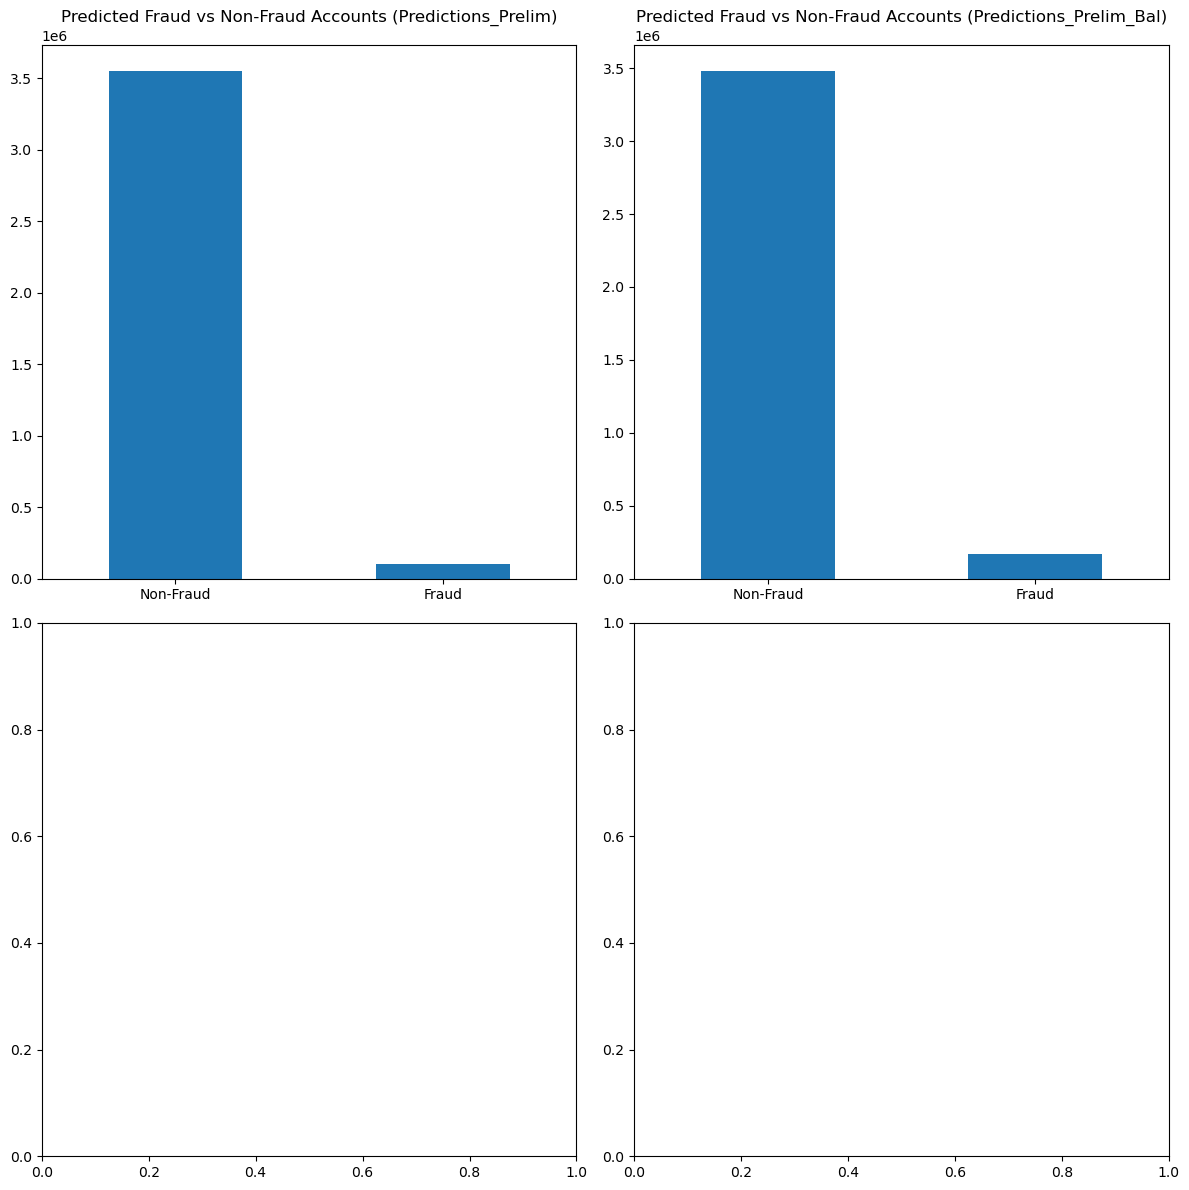

In [8]:
predictions_columns = ['Predictions_Prelim', 'Predictions_Prelim_Bal']

fig, axes = plt.subplots(2, 2, figsize=(12, 12)) # Change to 2x2 grid

for i, column in enumerate(predictions_columns):
    row = i // 2
    col = i % 2 
    
    # Show proportion of fraud vs non-fraud accounts
    test_set[column].value_counts().plot(kind='bar', ax=axes[row, col])
    axes[row, col].set_title(f"Predicted Fraud vs Non-Fraud Accounts ({column})")
    # Rename x label ticks
    axes[row, col].set_xticks([0, 1])
    axes[row, col].set_xticklabels(["Non-Fraud", "Fraud"], rotation=0)

    # Print percentage of fraud vs non-fraud accounts
    print(f"Percentage of Fraud Accounts ({column}): ", round(test_set[column].value_counts()[1] / len(test_set) * 100, 2), "%")
    print(f"Percentage of Non-Fraud Accounts ({column}): ", round(test_set[column].value_counts()[0] / len(test_set) * 100, 2), "%")

    # Print number of fraud vs non-fraud accounts
    print(f"Number of Fraud Accounts ({column}): ", test_set[column].value_counts()[1])
    print(f"Number of Non-Fraud Accounts ({column}): ", test_set[column].value_counts()[0])

    # Print additional information
    print(f"Number of known fraud accounts ({column}): ", test_set['Flag'].value_counts()[1])
    print(f"Number of known fraud accounts flagged correctly ({column}): ", test_set[(test_set['Flag'] == 1) & (test_set[column] == 1)].shape[0])
    print(f"Number of known fraud accounts flagged incorrectly ({column}): ", test_set[(test_set['Flag'] == 1) & (test_set[column] == 0)].shape[0])
    print(f"Unknown fraud accounts flagged ({column}): ", test_set[(test_set['Flag'] == 0) & (test_set[column] == 1)].shape[0])
    print("\n")

plt.tight_layout()
plt.show()

172
30
['0x63517fe71fcb339767aa6abd14ca10341dcf267d', '0x7da6e9a3280dab1e64a16ec992b9a87bf735e692', '0xc8eb927fe231c13c1117a1b9b4c85ba7d040404b', '0x055228cc05d47c99c44d5309fe753f4cec9dbb07', '0x9ec1bc5508f4e874aabac692380f45e51d344902', '0xb231227667566ed1ff81d53162aaaf87b681b3c8', '0x1f91d2d3ff8ce66dd75ab221f370c71c431dd659', '0xf8ccafea45e73ea9831f9aa125b72ef1884af3eb', '0x80962df3f2e22b96d582155733a94b2606be984c', '0x2a48eb888402f4af9bddb1526a69be3d23425c76', '0xf8e402f12917900afcd8daeda97b23aae524db9f', '0xabf0335422f27c01595f639e4d907d07d5e9b3e3', '0x02095d057ff161e53ec689ab17c34e6d65899b1d', '0x37f092b00fc5a70b7bfbd12e2672db764ac85060', '0xfb867e6a058209649085a112607feb34d08e3954', '0x0fa3202e9f247f9349352c4296d2bbd6c7fa11b4', '0xcdd4a3c2f43643bdc4a3ea3a4ac25e80ed08963f', '0x0a25f149b02d6c02e371f6b09f46905bb1f36a4b', '0x556ad0b1b25ca2198b65feddbe79c0c176bd8233', '0x443ca06b7ad3baeef015c1d6df3db168d2e9c691', '0x89a6c8e9f4536f04ceb13310b4e887da8ae7739c', '0x264363cfcd1ec5a0232558a

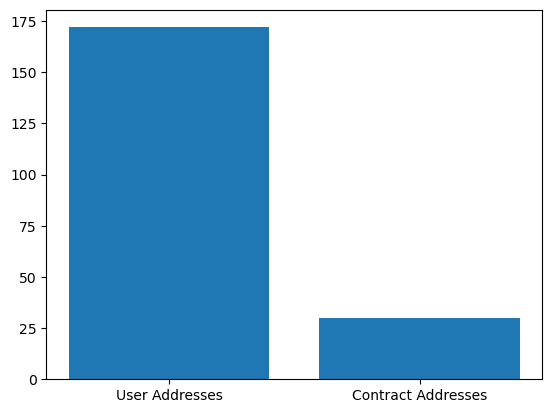

: 

In [14]:
test_set_prediction_addresses = test_set[(test_set['Predictions_Prelim_Bal'] == 0) & (test_set['Flag'] == 1)]['address'].tolist()

user_addresses = []
contract_addresses = []
api_keys = alchemy.get_api_keys()
alchemy_url = alchemy.get_api_url()

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as executor:
    future_to_address = {executor.submit(get_address_type, address, api_keys, alchemy_url): address for address in test_set_prediction_addresses}
    for future in concurrent.futures.as_completed(future_to_address):
        address = future_to_address[future]
        try:
            is_user_address = future.result()
            if is_user_address:
                user_addresses.append(address)
            else:
                contract_addresses.append(address)
        except TypeError as e:
            continue

print(len(user_addresses))
print(len(contract_addresses))
print(user_addresses)
print(contract_addresses)

#plot bar plot length of user_addresses vs contract_addresses
plt.bar(['User Addresses', 'Contract Addresses'], [len(user_addresses), len(contract_addresses)])
plt.show()

In [17]:
two_month_df = pd.read_parquet('data/parquet_files/train_two_month_with_scam_df_alt.parquet')
scam_addresses_in_train_test = pd.read_pickle('data/pickle_files/scam_addresses_in_train_test_alt.pkl')
fill_values = {'median_recency_out':0, 'median_recency_in':0, 'num_outliers_eth_out':0, 'num_outliers_eth_in': 0,
               'daily_from_gini_index': 1000, 'daily_to_gini_index': 1000, 'weekly_from_gini_index': 1000, 
               'weekly_to_gini_index': 1000, 'daily_total_gini_index': 1000, 'weekly_total_gini_index': 1000}
two_month_df = two_month_df.fillna(value=fill_values)
two_month_df['Flag'] = two_month_df['address'].apply(lambda x: 1 if x in scam_addresses_in_train_test else 0)

In [20]:
two_month_predictions_df = two_month_df[chosen_columns.append(pd.Index(['Flag']))]
X_two_month = two_month_predictions_df.drop(columns=['Flag'])
y_two_month = two_month_predictions_df['Flag']
two_month_pred = xgb_prelim_with_contract.predict(X_two_month)
two_month_pred_proba = xgb_prelim_with_contract.predict_proba(X_two_month)[:,1]
two_month_pred_bal = xgb_prelim_with_contract_bal.predict(X_two_month)
two_month_pred_bal_proba = xgb_prelim_with_contract_bal.predict_proba(X_two_month)[:,1]
two_month_df['Predictions_Imbalanced'] = two_month_pred
two_month_df['Predictions_Imbalanced_Proba'] = two_month_pred_proba
two_month_df['Predictions_Balanced'] = two_month_pred_bal
two_month_df['Predictions_Balanced_Proba'] = two_month_pred_bal_proba

Percentage of Fraud Accounts (Imbalanced):  2.95 %
Percentage of Non-Fraud Accounts (Imbalanced):  97.05 %
Number of Fraud Accounts (Imbalanced):  128276
Number of Non-Fraud Accounts (Imbalanced):  4217912
Number of known fraud accounts flagged correctly (Imbalanced):  42
Number of known fraud accounts flagged incorrectly (Imbalanced):  416
Unknown fraud accounts flagged (Imbalanced):  128234
Percentage of Fraud Accounts (Balanced):  3.38 %
Percentage of Non-Fraud Accounts (Balanced):  96.62 %
Number of Fraud Accounts (Balanced):  146704
Number of Non-Fraud Accounts (Balanced):  4199484
Number of known fraud accounts flagged correctly (Balanced):  42
Number of known fraud accounts flagged incorrectly (Balanced):  416
Unknown fraud accounts flagged (Balanced):  146662
Number of known fraud accounts:  458


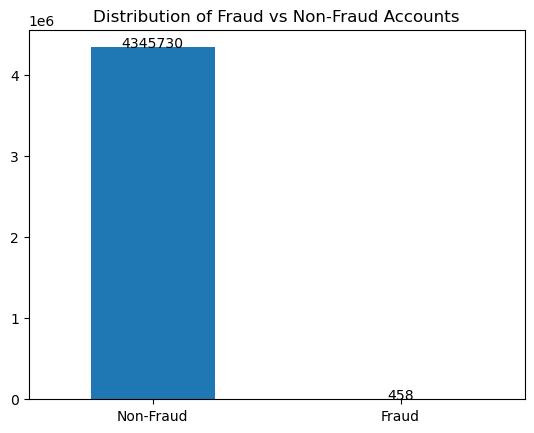

In [22]:
def print_statistics(df, method):
    fraud_percentage = round(df[f'Predictions_{method}'].value_counts()[1] / len(df) * 100, 2)
    non_fraud_percentage = round(df[f'Predictions_{method}'].value_counts()[0] / len(df) * 100, 2)
    fraud_count = df[f'Predictions_{method}'].value_counts()[1]
    non_fraud_count = df[f'Predictions_{method}'].value_counts()[0]

    known_fraud_flagged_correctly = df[(df['Flag'] == 1) & (df[f'Predictions_{method}'] == 1)].shape[0]
    known_fraud_flagged_incorrectly = df[(df['Flag'] == 1) & (df[f'Predictions_{method}'] == 0)].shape[0]
    unknown_fraud_flagged = df[(df['Flag'] == 0) & (df[f'Predictions_{method}'] == 1)].shape[0]

    print(f"Percentage of Fraud Accounts ({method}): ", fraud_percentage, "%")
    print(f"Percentage of Non-Fraud Accounts ({method}): ", non_fraud_percentage, "%")
    print(f"Number of Fraud Accounts ({method}): ", fraud_count)
    print(f"Number of Non-Fraud Accounts ({method}): ", non_fraud_count)
    print(f'Number of known fraud accounts flagged correctly ({method}): ', known_fraud_flagged_correctly)
    print(f'Number of known fraud accounts flagged incorrectly ({method}): ', known_fraud_flagged_incorrectly)
    print(f'Unknown fraud accounts flagged ({method}): ', unknown_fraud_flagged)

print_statistics(two_month_df, 'Imbalanced')
print_statistics(two_month_df, 'Balanced')

print('Number of known fraud accounts: ', two_month_df['Flag'].value_counts()[1])

two_month_df['Flag'].value_counts().plot(kind='bar')
plt.title("Distribution of Fraud vs Non-Fraud Accounts")
#rename x label ticks
plt.xticks([0,1], ["Non-Fraud", "Fraud"], rotation=0)
#add value of each bar above it
for i in range(len(two_month_df['Flag'].value_counts())):
    plt.text(x = i , y = two_month_df['Flag'].value_counts()[i], 
             s = two_month_df['Flag'].value_counts()[i], ha='center')
plt.show()

In [23]:
#rename Predictions_BOHB to Predictions, rename Predictions_Proba_BOHB to Predictions_Proba, drop Predictions_Random and Predictions_Proba_Random
two_month_df = two_month_df.rename(columns={'Predictions_Imbalanced': 'Predictions', 'Predictions_Imbalanced_Proba': 'Predictions_Proba'})
two_month_df = two_month_df.drop(columns=['Predictions_Balanced', 'Predictions_Balanced_Proba'])

In [27]:
two_month_df = two_month_df.iloc[:, :-4]

In [28]:
two_month_df['Flag_Predictions'] = two_month_df['Flag'].astype('str') + two_month_df['Predictions'].astype('str')

In [29]:
# Group by address and calculate the number of unique 'flag' and 'prediction' values for each address
grouped_pred = two_month_df.groupby('address').agg({'Predictions': 'nunique'})

# Filter for addresses where there are more than one unique 'flag' or 'prediction' value
different_pred = grouped_pred[(grouped_pred['Predictions'] > 1)]
# The number of instances where an address was flagged differently
num_different_flags = len(different_pred)

In [30]:
grouped_pred_list = different_pred.index.tolist()
different_pred_df = two_month_df[two_month_df['address'].isin(grouped_pred_list)]
known_fraud_different_pred_df = different_pred_df[(different_pred_df['Flag']==1)]

In [33]:
unique_addresses = known_fraud_different_pred_df['address'].unique().tolist()
print('Number dual flagged addresses in May and June:', len(unique_addresses))
print('Number of unique scam addresses May and June:', len(scam_addresses_in_train_test))
print('Number of dual flagged address in unique scam addresses:', len([x for x in unique_addresses if x in scam_addresses_in_train_test]))

false_negative_addresses = two_month_df[(two_month_df['Flag']==1) & (two_month_df['Predictions']==0)]
incorrectly_flagged_in_dual_flagged_addresses = [x for x in false_negative_addresses['address'] if x in unique_addresses]
print('Number of false negative addresses', len(false_negative_addresses))
print('Number of incorrectly flagged addresses in dual flagged accounts:', len(incorrectly_flagged_in_dual_flagged_addresses))

Number dual flagged addresses in May and June: 20
Number of unique scam addresses May and June: 631
Number of dual flagged address in unique scam addresses: 20
Number of false negative addresses 416
Number of incorrectly flagged addresses in dual flagged accounts: 20
